In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


CUDA available: False


In [3]:
class HarmfulDataset(Dataset):
    def __init__(self, frames_dir, mels_dir):
        self.frames_dir = frames_dir
        self.mels_dir = mels_dir
        self.samples = []
        self.categories = ["Adult Content", "Harmful Content", "Safe", "Suicide"]
        self.label_map = {cat: i for i, cat in enumerate(self.categories)}

        for f in os.listdir(frames_dir):
            if not f.endswith(".npy"):
                continue

            # Match category name inside filename
            f_lower = f.lower().replace("_", " ").replace("-", " ")
            label = None
            for cat in self.categories:
                if cat.lower().replace(" ", "") in f_lower.replace(" ", ""):
                    label = cat
                    break

            if label:
                frame_file = os.path.join(frames_dir, f)
                mel_file = os.path.join(mels_dir, f)
                if os.path.exists(mel_file):
                    self.samples.append((frame_file, mel_file, label))

        print(f"✅ Loaded {len(self.samples)} samples from {len(self.categories)} classes: {self.categories}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_path, mel_path, label_name = self.samples[idx]
        frames = np.load(frame_path).astype(np.float32) / 255.0
        mel = np.load(mel_path).astype(np.float32)

        # Convert to torch tensors
        frames = torch.tensor(frames).permute(3, 0, 1, 2)  # (C, T, H, W)
        mel = torch.tensor(mel).unsqueeze(0)               # (1, mel_bins, time)
        label = torch.tensor(self.label_map[label_name]).long()

        return frames, mel, label


In [4]:
frames_dir = r"E:\archive\Dataset\processed_data\frames"
mels_dir = r"E:\archive\Dataset\processed_data\mels"

dataset = HarmfulDataset(frames_dir, mels_dir)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


✅ Loaded 3948 samples from 4 classes: ['Adult Content', 'Harmful Content', 'Safe', 'Suicide']
Train samples: 3158, Validation samples: 790


In [5]:
class CNN_BiLSTM(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_BiLSTM, self).__init__()

        # CNN for image features
        self.cnn = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2))
        )

        # BiLSTM for sequence (time) modeling
        self.lstm = nn.LSTM(64*28*28, 128, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(128*2, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, frames, mel):
        # CNN output: (B, C, T, H, W)
        x = self.cnn(frames)
        x = x.permute(0, 2, 1, 3, 4)  # (B, T, C, H, W)
        x = x.reshape(x.size(0), x.size(1), -1)  # (B, T, features)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # last timestep
        x = F.relu(self.fc1(lstm_out))
        x = self.fc2(x)
        return x


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = CNN_BiLSTM(num_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

epochs = 10
train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(epochs):
    model.train()
    total, correct, epoch_loss = 0, 0, 0
    for frames, mels, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        frames, labels = frames.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames, mels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_losses.append(epoch_loss / len(train_loader))
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_total, val_correct, val_loss = 0, 0, 0
    with torch.no_grad():
        for frames, mels, labels in val_loader:
            frames, labels = frames.to(dev ice), labels.to(device)
            outputs = model(frames, mels)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}% | Val Acc={val_acc:.2f}%")


Using device: cpu


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 395/395 [14:50<00:00,  2.25s/it]


Epoch 1: Train Acc=40.98% | Val Acc=47.09%


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 395/395 [15:37<00:00,  2.37s/it]


Epoch 2: Train Acc=48.29% | Val Acc=38.48%


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 395/395 [15:40<00:00,  2.38s/it]


Epoch 3: Train Acc=52.50% | Val Acc=54.94%


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 395/395 [15:59<00:00,  2.43s/it]


Epoch 4: Train Acc=57.09% | Val Acc=53.29%


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 395/395 [15:20<00:00,  2.33s/it]


Epoch 5: Train Acc=63.24% | Val Acc=56.33%


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 395/395 [15:42<00:00,  2.39s/it]


Epoch 6: Train Acc=70.30% | Val Acc=53.04%


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 395/395 [16:19<00:00,  2.48s/it]


Epoch 7: Train Acc=80.68% | Val Acc=51.65%


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 395/395 [14:34<00:00,  2.21s/it]


Epoch 8: Train Acc=88.35% | Val Acc=57.85%


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 395/395 [14:48<00:00,  2.25s/it]


Epoch 9: Train Acc=94.62% | Val Acc=59.62%


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 395/395 [14:55<00:00,  2.27s/it]


Epoch 10: Train Acc=97.50% | Val Acc=58.99%


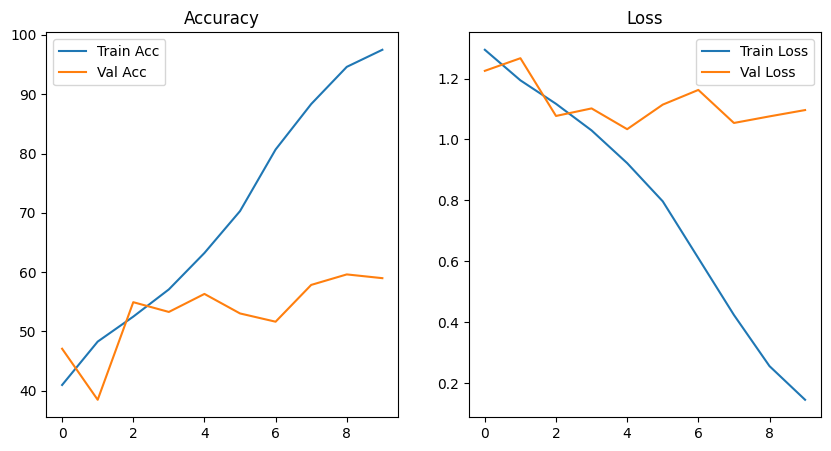

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss")
plt.show()


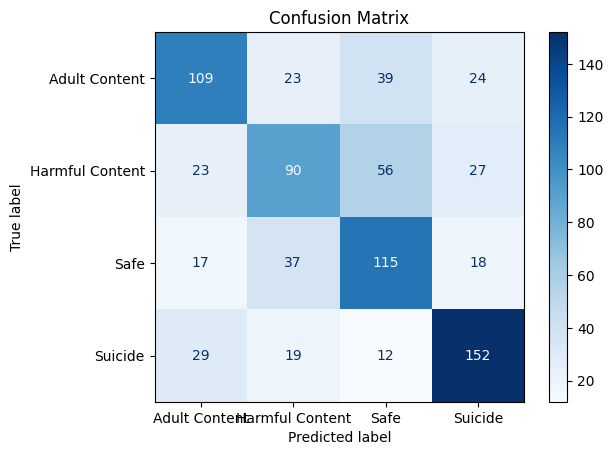

                 precision    recall  f1-score   support

  Adult Content       0.61      0.56      0.58       195
Harmful Content       0.53      0.46      0.49       196
           Safe       0.52      0.61      0.56       187
        Suicide       0.69      0.72      0.70       212

       accuracy                           0.59       790
      macro avg       0.59      0.59      0.59       790
   weighted avg       0.59      0.59      0.59       790



In [8]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for frames, mels, labels in val_loader:
        frames, labels = frames.to(device), labels.to(device)
        outputs = model(frames, mels)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=dataset.categories)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds, target_names=dataset.categories))
